In [56]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import random

In [57]:
tf.random.set_seed(50)

In [58]:
dataset, info = tfds.load('eurosat', with_info=True, as_supervised=True)
full_ds = dataset['train']

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
image_shape = info.features['image'].shape
image_dtype = info.features['image'].tf_dtype

print("===== EuroSAT Dataset Info =====")
print(f"Number of examples: {num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Image shape: {image_shape}")
print(f"Image dtype: {image_dtype}")

===== EuroSAT Dataset Info =====
Number of examples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Image shape: (64, 64, 3)
Image dtype: <dtype: 'uint8'>


In [59]:
# Resize and normalize

def resize_and_rescale(image, label, target=224):
    image = tf.image.resize(image, [target, target])    #resize images from 64×64 to 224×224
    image = tf.cast(image, tf.float32) / 255.0     #convert pixel type
    return image, label

In [60]:
full_ds = full_ds.map(resize_and_rescale)

In [61]:
num_examples = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * num_examples)  
val_size   = int(0.15 * num_examples)  

# 70% train, 15% val, 15% test

train_ds = full_ds.take(train_size)
# Remaining 30%
remaining = full_ds.skip(train_size)

val_ds = remaining.take(val_size)

test_ds = remaining.skip(val_size)

# how many examples in each split
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count   = tf.data.experimental.cardinality(val_ds).numpy()
test_count   = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Train examples: {train_count}, Val examples: {val_count}, Test examples: {test_count}")

Train examples: 18900, Val examples: 4050, Test examples: 4050


In [62]:
# Inspect class counts (detect imbalance)
counts = collections.Counter() #dictionary-like object that counts occurrences of items
y_train_list = []


for _, lbl in tfds.as_numpy(train_ds):
    counts[int(lbl)] += 1
    y_train_list.append(int(lbl))

print("Per-class counts (train):")
for cls in sorted(counts.keys()):
    print(f"  class {cls}: {counts[cls]} images")


Per-class counts (train):
  class 0: 2122 images
  class 1: 2143 images
  class 2: 2067 images
  class 3: 1756 images
  class 4: 1756 images
  class 5: 1382 images
  class 6: 1718 images
  class 7: 2095 images
  class 8: 1754 images
  class 9: 2107 images


In [63]:
# no class imbalance, so we'll apply light augmentation just to
# improve model training and generalization and reduce overfitting

#minimal light augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [64]:
#apply augmentation to the training dataset only

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y))

In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub

In [66]:
url = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"
base_model = hub.KerasLayer(url, trainable=False, name="inception_v1_base")


In [67]:
# build the model

inputs = layers.Input(shape=(224, 224, 3))

# Wrap hub_layer with Lambda
features = layers.Lambda(lambda t: base_model(t), name='hub_wrapper')(inputs)

x = layers.Dense(256, activation='relu')(features) #extra hidden layer

prediction_layer = layers.Dense(10, activation='softmax')(x)

InceptionModel = models.Model(inputs = inputs, outputs = prediction_layer)

InceptionModel.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_wrapper (Lambda)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,970 (1.01 MB)

 Trainable params: 264,970 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Compile model (optimizer updates model's weights to reduce loss)
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

InceptionModel.compile(
    optimizer = optimizer,
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"])


In [69]:
# Train model
Batch_size = 64

train_ds = train_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

history = InceptionModel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


296/296 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.8842 - loss: 0.3583 - val_accuracy: 0.9232 - val_loss: 0.2267
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - accuracy: 0.9279 - loss: 0.2130 - val_accuracy: 0.9296 - val_loss: 0.2096
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1124s 4s/step - accuracy: 0.9334 - loss: 0.1940 - val_accuracy: 0.9257 - val_loss: 0.2227
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1061s 4s/step - accuracy: 0.9381 - loss: 0.1740 - val_accuracy: 0.9437 - val_loss: 0.1806
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 990s 3s/step - accuracy: 0.9451 - loss: 0.1604 - val_accuracy: 0.9383 - val_loss: 0.1904
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 962s 3s/step - accuracy: 0.9437 - loss: 0.1580 - val_accuracy: 0.9452 - val_loss: 0.1746
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 968s 3s/step - accuracy: 0.9475 - loss: 0.1519 - val_accuracy: 0.9464 - val_loss: 0.1803
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.9494 - loss: 0.1412 - val_accuracy: 0.9

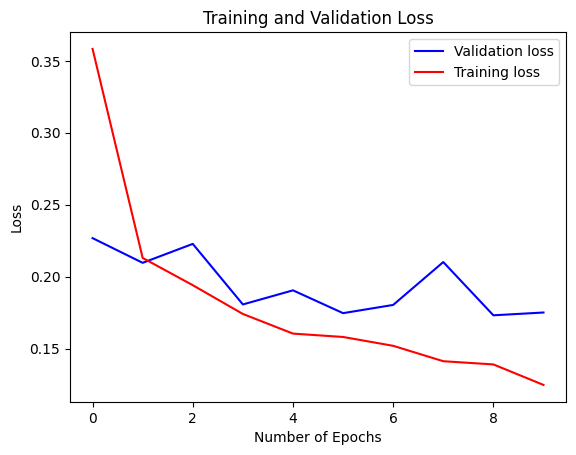

In [70]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="Validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

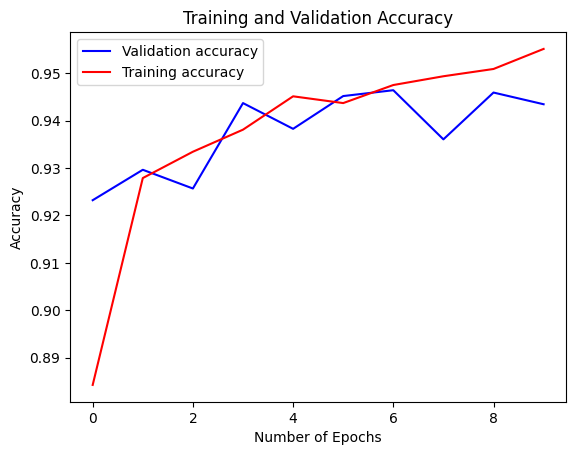

In [71]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_accuracy'], color='b', label="Validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="Training accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [72]:
test_ds = test_ds.batch(Batch_size)
y_prob = InceptionModel.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)  #to get class index since we're using soft max

y_true = np.concatenate([y for x, y in test_ds], axis=0)   # true labels

64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 831ms/step


In [73]:
# Evaluate model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc= accuracy_score(y_true, y_pred)
prec= precision_score(y_true, y_pred, average='macro')
rec= recall_score(y_true, y_pred, average='macro')
f1= f1_score(y_true, y_pred, average='macro')

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

Accuracy : 0.9469135802469136
Precision: 0.9460793099648261
Recall   : 0.9435973027570874
F1-score : 0.9441292555026413


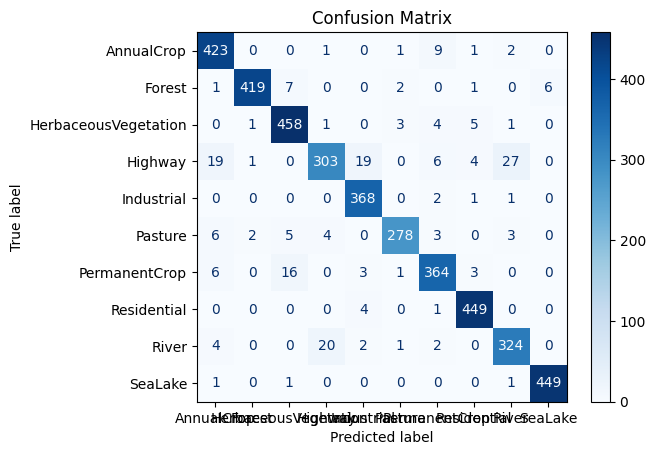

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()

In [75]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# y_true must be one-hot / binarized
y_true_bin = label_binarize(y_true, classes=range(10))
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, multi_class="ovr", average="macro")
print("Macro-average ROC AUC:", roc_auc_macro)

Macro-average ROC AUC: 0.998137097585132


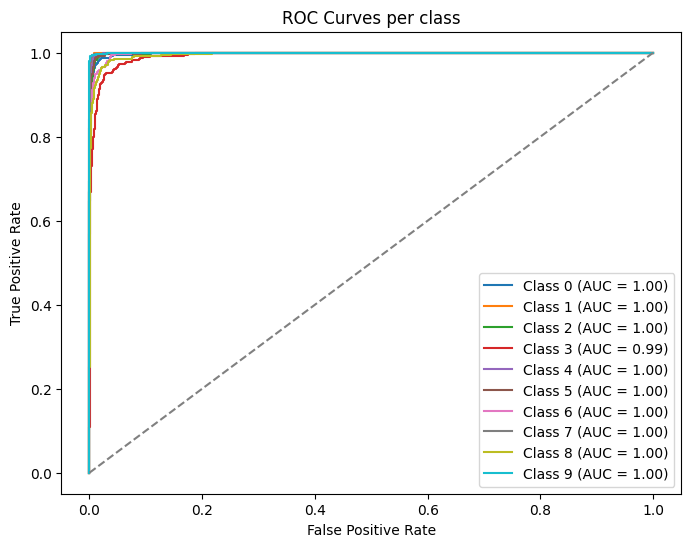

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per class")
plt.legend()
plt.show()